## Trying to predict VALE3 returns through Decision Trees

As already stated in the project's READ.ME, this was only a inicial attempt in this field. Surely there are many machine learning algorithms and possible modifications or restructurings of data that could get a better accuracy in the predictions made. Nevertheless, it was interesting to see how a simple machine learning model like a Decision Tree responds to the "stock returns prediction" academic field.

Period of analysis: 26/09/2011 - 08/04/2022 <br>
Assets: VALE3, CC Fut BVSP, CC Fut USD/BRL, Iron Ore 62% Fe CFR and CSI 1000 (China)

### Packages

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools


from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## DATA

### Data imported from "investing.com"

In [225]:
# VALE3
dadosbrutos_vale3 = pd.read_csv("VALE3 Dados Históricos.csv")
# CC Fut BVSP
dadosbrutos_ibov = pd.read_csv("Futuros Mini Ibovespa - Dados Históricos.csv")
# CC Fut USD/BRL
dadosbrutos_mini_dolar = pd.read_csv("Mini Dólar Futuros Dados Históricos.csv")
# Iron Ore 62% Fe CFR
dadosbrutos_minferro = pd.read_csv("Minério de ferro refinado 62_ Fe CFR Futuros Dados Históricos.csv")
# CSI 1000 (China)
dadosbrutos_china = pd.read_csv("CSI 1000 Dados Históricos.csv")

### Cleaning Data

In [226]:
# VALE3
dadosbrutos_vale3 = dadosbrutos_vale3.drop(["Último", "Abertura", "Máxima", "Mínima", "Vol."], axis=1)
dadosbrutos_vale3.rename(columns = {"Var%":"VALE3"}, inplace = True)
dadosbrutos_vale3["VALE3"] = [c.replace(',', '.') for c in dadosbrutos_vale3["VALE3"]]
dadosbrutos_vale3["VALE3"] = dadosbrutos_vale3["VALE3"].str.rstrip("%").astype("float") / 100.0

# MINI_IBOV
dadosbrutos_ibov = dadosbrutos_ibov.drop(["Último", "Abertura", "Máxima", "Mínima", "Vol."], axis=1)
dadosbrutos_ibov.rename(columns = {"Var%":"IBOV"}, inplace = True)
dadosbrutos_ibov["IBOV"] = [c.replace(',', '.') for c in dadosbrutos_ibov["IBOV"]]
dadosbrutos_ibov["IBOV"] = dadosbrutos_ibov["IBOV"].str.rstrip("%").astype("float") / 100.0

# MINI_DOLAR
dadosbrutos_mini_dolar = dadosbrutos_mini_dolar.drop(["Último", "Abertura", "Máxima", "Mínima", "Vol."], axis=1)
dadosbrutos_mini_dolar.rename(columns = {"Var%":"DOLFUT"}, inplace = True)
dadosbrutos_mini_dolar["DOLFUT"] = [c.replace(',', '.') for c in dadosbrutos_mini_dolar["DOLFUT"]]
dadosbrutos_mini_dolar["DOLFUT"] = dadosbrutos_mini_dolar["DOLFUT"].str.rstrip("%").astype("float") / 100.0

# Min_Ferro
dadosbrutos_minferro = dadosbrutos_minferro.drop(["Último", "Abertura", "Máxima", "Mínima", "Vol."], axis=1)
dadosbrutos_minferro.rename(columns = {"Var%":"Min_Ferro"}, inplace = True)
dadosbrutos_minferro["Min_Ferro"] = [c.replace(',', '.') for c in dadosbrutos_minferro["Min_Ferro"]]
dadosbrutos_minferro["Min_Ferro"] = dadosbrutos_minferro["Min_Ferro"].str.rstrip("%").astype("float") / 100.0

# China
dadosbrutos_china = dadosbrutos_china.drop(["Último", "Abertura", "Máxima", "Mínima", "Vol."], axis=1)
dadosbrutos_china.rename(columns = {"Var%":"CHINA"}, inplace = True)
dadosbrutos_china["CHINA"] = [c.replace(',', '.') for c in dadosbrutos_china["CHINA"]]
dadosbrutos_china["CHINA"] = dadosbrutos_china["CHINA"].str.rstrip("%").astype("float") / 100.0

### Merging Data

1) Seeing what is the size of each dataframe

In [227]:
print(f"VALE3 shape: {dadosbrutos_vale3.shape}")
print(f"BVSP shape: {dadosbrutos_ibov.shape}")
print(f"USDFUT shape: {dadosbrutos_mini_dolar.shape}")
print(f"IRON_ORE shape: {dadosbrutos_minferro.shape}")
print(f"CHINA shape: {dadosbrutos_china.shape}")

VALE3 shape: (2607, 2)
BVSP shape: (2619, 2)
USDFUT shape: (2604, 2)
IRON_ORE shape: (2645, 2)
CHINA shape: (2560, 2)


2) Merging and reordering columns

In [228]:
temp_list = [dadosbrutos_ibov, dadosbrutos_mini_dolar, dadosbrutos_minferro, dadosbrutos_china]

full_data = dadosbrutos_vale3
for i in temp_list:
    full_data = full_data.merge(i, on="Data", how="right")

full_data = full_data.dropna(axis=0)
full_data = full_data[["Data", "IBOV", "DOLFUT", "Min_Ferro", "CHINA", "VALE3"]]
full_data

,Data,IBOV,DOLFUT,Min_Ferro,CHINA,VALE3
0,26.09.2011,0.0080,0.0000,-0.0011,-0.0151,-0.0133
1,27.09.2011,0.0045,-0.0283,-0.0011,0.0035,0.0111
2,28.09.2011,-0.0163,0.0145,-0.0006,-0.0188,-0.0047
3,29.09.2011,0.0055,0.0000,-0.0017,-0.0388,-0.0063
5,10.10.2011,0.0435,-0.0119,-0.0072,-0.0036,0.0314
...,...,...,...,...,...,...
2553,31.03.2022,-0.0043,0.0015,0.0015,-0.0131,-0.0028
2554,01.04.2022,0.0130,-0.0169,0.0597,0.0001,0.0142
2555,06.04.2022,-0.0051,0.0107,-0.0073,-0.0013,0.0151
2556,07.04.2022,0.0048,0.0082,-0.0174,-0.0204,0.0060


3) As we want to try to predict VALE3 returns, we need to use yesterday's data of the independent variables, so we shift their data one row down, and drop the NaN row generated

In [229]:
for i in full_data.drop(["VALE3"], axis=1).columns:
    full_data[i] = full_data[i].shift(1)

full_data = full_data.dropna(axis=0)

### Transforming continuous returns into "bands"

In [230]:
bands_rule = pd.read_excel("pricebands_rule.xlsx")
bands_rule

,band number,interval
0,6,3% to 100%
1,5,1.5% to 3%
2,4,0% to 1.5%
3,3,-1.5% to 0%
4,2,-3% to -1.5%
5,1,-100% to -3%


In [231]:
full_data = full_data.drop(["Data"], axis=1)

In [232]:
bands_fulldata = pd.DataFrame()

for i in full_data.columns:
    conditions = [
        (full_data[i] <  -0.03),
        (full_data[i] >= -0.03)  & (full_data[i] < -0.015),
        (full_data[i] >= -0.015) & (full_data[i] <  0),
        (full_data[i] >=  0)     & (full_data[i] <  0.015),
        (full_data[i] >=  0.015) & (full_data[i] <  0.03),
        (full_data[i] >  0.03)
                ]

    values = ['1', '2', '3', '4', '5', '6']


    bands_fulldata[f'band_{i}'] = np.select(conditions, values)

In [233]:
bands_fulldata

,band_IBOV,band_DOLFUT,band_Min_Ferro,band_CHINA,band_VALE3
0,4,4,3,2,4
1,4,2,3,4,3
2,2,4,3,2,3
3,4,4,3,1,6
4,6,3,3,3,4
...,...,...,...,...,...
2360,4,4,4,5,3
2361,3,4,4,3,4
2362,4,2,6,4,5
2363,3,4,3,3,4


## DECISION TREE MODEL

1) Separating data into independent and dependent variables

In [234]:
X = bands_fulldata.drop(["band_VALE3"], axis=1)
Y = bands_fulldata["band_VALE3"]

2) Making a train_test split 

In [235]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

3) Training and testing the model accuracy

In [236]:
model = DecisionTreeClassifier()

model.fit(X=X_train, y=Y_train)
predictions = model.predict(X_test)
print(f"The model accuracy was: {round(accuracy_score(Y_test, predictions), 4)}")

The model accuracy was: 0.2558


4) The image is too big, but just as a visual representation, this was the decision tree created:

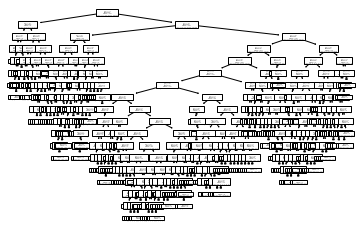

In [237]:
tree.plot_tree(model)
plt.show()

<br>

<br>

#### Extra: splitting data, training and testing 20 different models, and calculating their average accuracy

In [223]:
multiple_DT = pd.DataFrame()

for i in range(20):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)
    obs_model = DecisionTreeClassifier()
    obs_model.fit(X=X_train, y=Y_train)
    obs_predictions = obs_model.predict(X_test)
    multiple_DT[i] = [accuracy_score(Y_test, obs_predictions)]
 
multiple_DT = multiple_DT.transpose()
multiple_DT.columns = ["Accuracy"]

print(f"The average accuracy was: {round(np.mean(multiple_DT.iloc[:,0]), 4)}")
multiple_DT

The average accuracy was: 0.2493


,Accuracy
0,0.270613
1,0.253700
2,0.255814
3,0.234672
4,0.236786
5,0.255814
6,0.230444
7,0.257928
8,0.249471
9,0.283298
